In [1]:
# importation des librairies nécessaires à l'exploration
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, prediction_error

In [2]:
sklearn.set_config(display="diagram")

In [3]:
def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** (1/2)
    r_score = r2_score(y_test, y_pred)
    print("MAE :",mae.round(5))
    print("MSE :", mse.round(5))
    print("RMSE :", rmse.round(5))
    print("R² :", r_score.round(5))

In [4]:
data = pd.read_csv("datasets/benchmark_total.csv")

In [5]:
data.head(3)

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
0,Hotel,Downtown,1927,1.0,12.0,88434,65.0,6981428.0,249.43
1,Hotel,Downtown,1996,1.0,11.0,103566,51.0,8354235.0,263.51
2,Hotel,Downtown,1969,1.0,41.0,961990,18.0,73130656.0,2061.48


In [6]:
y_energy = data["SiteEnergyUse(kBtu)"].values
y_ghg = data["TotalGHGEmissions"].values
X = data.drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"], axis=1)

In [7]:
y_energy = np.log1p(y_energy)
y_ghg = np.log1p(y_ghg)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_energy, test_size=0.2, random_state=42)

In [9]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Prédiction de la consommation d'énergie

## Création d'un modèle "baseline"

### Préparation des données

In [10]:
cat_var = ["PrimaryPropertyType", "Neighborhood"]
num_var = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal"]

In [11]:
from sklearn.impute import SimpleImputer


imputer_cat = SimpleImputer(strategy="most_frequent")
imputer_cat.fit(X_train[cat_var])

SimpleImputer(strategy='most_frequent')

In [12]:
imputer_num = SimpleImputer(strategy="median")
imputer_num.fit(X_train[num_var])

SimpleImputer(strategy='median')

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num_var])

StandardScaler()

In [14]:
X_train[num_var] = scaler.transform(X_train[num_var])
X_train[num_var] = imputer_num.transform(X_train[num_var])
X_train[cat_var] = imputer_cat.transform(X_train[cat_var])

In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(X_train[cat_var])
X_train = enc.transform(X_train[cat_var])

### Création du modèle de base

In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

### Evaluation du modèle avec le jeu de test

In [17]:
X_test[num_var] = imputer_num.transform(X_test[num_var])
X_test[cat_var] = imputer_cat.transform(X_test[cat_var])

In [18]:
X_test = enc.transform(X_test[cat_var])

In [19]:
y_pred = lin_reg.predict(X_test)

In [20]:
regression_metrics(y_test, y_pred)

MAE : 0.88197
MSE : 1.53538
RMSE : 1.23911
R² : 0.21679


## Choix du modèle le plus performant

In [21]:
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

lin_reg = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
sgd_reg = SGDRegressor(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)

In [22]:
model = [lin_reg, ridge, lasso, sgd_reg, dt_reg, svm_reg, ridge_kernel, adaboost, bagging, gdboost, rdmforest, xgboost]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** (1/2)
    r_score = r2_score(y_test, y_pred)
    dict_model[model] = (mae, mse, rmse, r_score)

In [23]:
eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Linear Regression", "Ridge", "Lasso", "SGDRegressor", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest", "XGBoost"]

eval_model

,Linear Regression,Ridge,Lasso,SGDRegressor,DecisionTree,SVM,Ridge Kernel,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost
MAE,0.881971,0.882088,1.044332,0.909231,0.874902,0.856886,0.889525,1.133803,0.874927,0.866702,0.875727,0.873936
MSE,1.535382,1.534531,1.974720,1.631074,1.463919,1.486527,1.544304,2.324560,1.453389,1.472891,1.457998,1.461424
RMSE,1.239105,1.238762,1.405247,1.277135,1.209925,1.219232,1.242700,1.524651,1.205566,1.213627,1.207476,1.208894
R²,0.216786,0.217220,-0.007326,0.167972,0.253240,0.241707,0.212234,-0.185782,0.258611,0.248663,0.256260,0.254512


**Choix du modèle :** RandomForest

## Choix des hyperparamètres

In [24]:
forest_reg = RandomForestRegressor(random_state=42)

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=500),
        'max_features': randint(low=1, high=6),
    }

random_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                             n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CAFD13C9D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CAFD13C4C0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [26]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.3174544361602065 {'max_features': 4, 'n_estimators': 349}
1.3168536906482322 {'max_features': 3, 'n_estimators': 72}
1.3175000008929365 {'max_features': 5, 'n_estimators': 21}
1.317931193530902 {'max_features': 2, 'n_estimators': 467}
1.31770683936195 {'max_features': 3, 'n_estimators': 459}
1.3163801332336158 {'max_features': 5, 'n_estimators': 100}
1.3167304080880127 {'max_features': 3, 'n_estimators': 150}
1.317276979516911 {'max_features': 5, 'n_estimators': 258}
1.3178607787980094 {'max_features': 4, 'n_estimators': 414}
1.318314460550182 {'max_features': 2, 'n_estimators': 192}


In [27]:
from sklearn.model_selection import GridSearchCV

params = [{'n_estimators' : [90, 100, 110, 120, 130, 140, 150],
           'max_features' : [3, 5]}]

grid_search = GridSearchCV(forest_reg, params, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [3, 5],
                          'n_estimators': [90, 100, 110, 120, 130, 140, 150]}],
             scoring='neg_mean_squared_error')

In [28]:
grid_search.best_params_

{'max_features': 3, 'n_estimators': 130}

In [29]:
grid_search.best_estimator_

RandomForestRegressor(max_features=3, n_estimators=130, random_state=42)

## Analyse des erreurs du modèle

In [30]:
final_model = grid_search.best_estimator_

In [31]:
final_predictions = final_model.predict(X_test)

In [32]:
regression_metrics(y_test, final_predictions)

MAE : 0.87697
MSE : 1.45851
RMSE : 1.20769
R² : 0.256


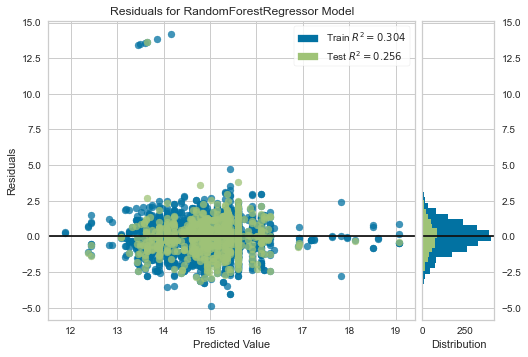

In [33]:
visualizer = ResidualsPlot(final_model)
visualizer.fit(X_train, y_train.reshape(2624,))
visualizer.score(X_test, y_test.reshape(657,))
visualizer.show();

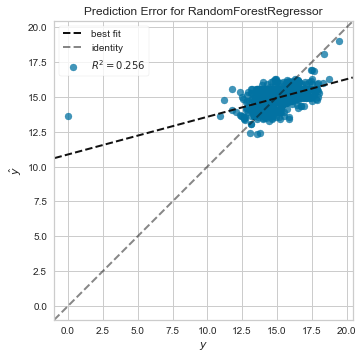

In [34]:
visualizer = prediction_error(final_model, X_train, y_train, X_test, y_test);

## Pipeline du modèle pour l'estimation de la consommation d'énergie

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_variables = list(num_var)
cat_variables = list(cat_var)

full_transformer = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), StandardScaler(), num_variables),
    ("cat", SimpleImputer(strategy="most_frequent"), OneHotEncoder(), cat_variables),
])

full_pipeline_with_model = Pipeline([
    ("preprocessing", full_transformer),
    ("modeling", RandomForestRegressor(max_features=3, n_estimators=130, random_state=42))
])

full_pipeline_with_model.fit(X_train, y_train)

# Prédiction des émissions de CO2